    Ben Christensen
    Math 321
    October 25, 2017

Use a k-d tree to solve the Nearest Neighbor problem and use this solution to identify images of numbers used in postal service data.

In [1]:
import sys
sys.path.insert(1, "/Users/benchristensen/Desktop/ACME Python Labs/Volume2-Student-Materials/Trees")
from trees import BSTNode, BST
import numpy as np
from scipy import linalg as la
import pdb
from scipy.spatial import KDTree
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# Problem 1
def metric(x, y):
    """Return the Euclidean distance between the 1-D arrays 'x' and 'y'.

    Raises:
        ValueError: if 'x' and 'y' have different lengths.

    Example:
        >>> metric([1,2],[2,2])
        1.0
        >>> metric([1,2,1],[2,2])
        ValueError: Incompatible dimensions.
    """
    if np.shape(x) != np.shape(y):
        raise ValueError("Incompatible dimensions.")
    return la.norm(x-y)


# Problem 2
def exhaustive_search(data_set, target):
    """Solve the nearest neighbor search problem exhaustively. Check the distances between 'target' and each point in 'data_set'. Use the Euclidean metric to calculate distances.

    Parameters:
        data_set ((m,k) ndarray): An array of m k-dimensional points.
        target ((k,) ndarray): A k-dimensional point to compare to 'dataset'.

    Returns:
        ((k,) ndarray) the member of 'data_set' that is nearest to 'target'.
        (float) The distance from the nearest neighbor to 'target'.
    """
    distance = la.norm(data_set[0,:] - target)
    nearest = data_set[0, :]
    for i in range(np.shape(data_set)[0]):
        if la.norm(data_set[i, :] - target) < distance:
            nearest = data_set[i, :]
            distance = la.norm(data_set[i, :] - target)
    return nearest, distance


# Problem 3: Write a KDTNode class.
class KDTNode(BSTNode):
    """A Node class for K-Dimension Trees. Contains vector-form data, axis value,
    a reference to the parent node, and references to two child nodes.
    """

    def __init__(self, data):
        """Construct a new node and set the data attribute. If the
        input data is not an ndarray, raise a typeerror.
        """
        BSTNode.__init__(self, data)
        if type(data) is not np.ndarray:
            raise TypeError("KDT Nodes can only hold numpy arrays.")
        self.axis = None


# Problem 4: Finish implementing this class by overriding
#            the __init__(), insert(), and remove() methods.
class KDT(BST):
    """A k-dimensional binary search tree object. Used to solve the nearest neighbor problem efficiently.

    Attributes:
        root (KDTNode): The root node of the tree. Like all other nodes in the
            tree, the root houses data as a NumPy array.
        k (int): The dimension of the tree (the 'k' of the k-d tree).
    """
    def __init__(self):
        """Initialize the dimension attribute."""
        BST.__init__(self)
        self.dimension = 0


    def find(self, data):
        """Return the node containing 'data'. If there is no such node in the tree, or if the tree is empty, raise a ValueError.
        """

        # Define a recursive function to traverse the tree.
        def _step(current):
            """Recursively step through the tree until the node containing 'data' is found. If there is no such node, raise a Value Error.
            """
            if current is None:                     # Base case 1: dead end.
                raise ValueError(str(data) + " is not in the tree")
            elif np.allclose(data, current.value):
                return current                      # Base case 2: data found!
            elif data[current.axis] < current.value[current.axis]:
                return _step(current.left)          # Recursively search left.
            else:
                return _step(current.right)         # Recursively search right.

        # Start the recursion on the root of the tree.
        return _step(self.root)

    def insert(self, data):
        """Insert a new node containing 'data' at the appropriate location.
        Return the new node. This method should be similar to BST.insert().
        """
        def _step(current):
            #Check if the node is already in the tree
            if np.allclose(data, current.value):
                raise ValueError(str(data) + " is already in the tree")
            #If at a leaf, insert to the appropriate side
            elif data[current.axis] < current.value[current.axis]:
                if current.left is None:
                    current.left = KDTNode(data)
                    current.left.prev = current
                    if current.axis == self.dimension - 1:
                        current.left.axis = 0
                    else:
                        current.left.axis = current.axis + 1
                    return current.left
                else:
                    return _step(current.left)
            elif data[current.axis] >= current.value[current.axis]:
                if current.right is None:
                    current.right = KDTNode(data)
                    current.right.prev = current
                    if current.axis == self.dimension - 1:
                        current.right.axis = 0
                    else:
                        current.right.axis = current.axis + 1
                    return current.right
                else:
                    return _step(current.right)
        # Start the recursion on the root of the tree.
        if self.root is None:
            self.root = KDTNode(data)
            self.root.axis = 0
            self.dimension = len(self.root.value)
        else:
            return _step(self.root)

    def remove(self, **kwargs):
        """Raise an error so they don't try to remove a node."""
        raise NotImplementedError("You are not allowed to remove")


# Problem 5
def nearest_neighbor(data_set, target):
    """Use your KDT class to solve the nearest neighbor problem.

    Parameters:
        data_set ((m,k) ndarray): An array of m k-dimensional points.
        target ((k,) ndarray): A k-dimensional point to compare to 'dataset'.

    Returns:
        The point in the tree that is nearest to 'target' ((k,) ndarray).
        The distance from the nearest neighbor to 'target' (float).
    """
    m,k = np.shape(data_set)
    my_KDT = KDT()
    for row in range(m):
        my_KDT.insert(data_set[row, :])
    distance = metric(my_KDT.root.value, target)


    def KDTsearch(current, neighbor, dist):
        """The actual nearest neighbor search algorithm.

        Parameters:
            current (KDTNode): the node to examine.
            neighbor (KDTNode): the current nearest neighbor.
            distance (float): the current minimum distance.

        Returns:
            (ndarray): The new nearest neighbor in the tree.
            (float): The new minimum distance.
        """
        if current is None:
            return neighbor, dist
        index = current.axis
        if metric(current.value, target) < dist:
            neighbor = current
            dist = metric(current.value, target)
        if target[index] < current.value[index]:
            neighbor, dist = KDTsearch(current.left, neighbor, dist)
            if target[index] + dist >= current.value[index]:
                neighbor, dist = KDTsearch(current.right, neighbor, dist)
        else:
            neighbor, dist = KDTsearch(current.right, neighbor, dist)
            if target[index] - dist <= current.value[index]:
                neighbor, dist = KDTsearch(current.left, neighbor, dist)
        return neighbor, dist

    ans1, ans2 = KDTsearch(my_KDT.root, my_KDT.root, distance)
    return ans1.value, ans2

# Problem 6
class KNeighborsClassifier(object):
    """A k-nearest neighbors classifier object. Uses SciPy's KDTree to solve
    the nearest neighbor problem efficiently.
    """

    def __init__(self, data, labels):
        """Initialize the training set and labels. Construct the KDTree from
        the training data.

        Parameters:
            data (ndarray): Training data.
            labels (ndarray): Corresponding labels for the training data.
        """
        self.tree = KDTree(data)
        self.labels = labels

    def predict(self, testpoints, k):
        """Predict the label of a new data point by finding the k-nearest
        neighbors.

        Parameters:
            testpoints (ndarray): New data point(s) to label.
            k (int): Number of neighbors to find.
        """
        predictions = []
        if testpoints.ndim == 1:
            n = 1
            testpoints = [testpoints]
        else:
            n = np.shape(testpoints)[1]
        for p in range(n):
            voting = []
            min_distances, indicies = self.tree.query(testpoints[p], k)
            for j in range(k):
                voting.append(self.labels[indicies[j]])
            predictions.append(stats.mode(voting)[0][0])
        return np.array(predictions)



My prediction:  [1]
Label:  1


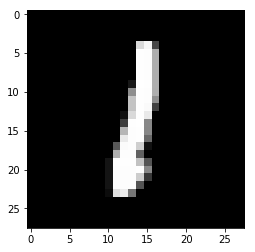

In [4]:
points, testpoints, labels, testlabels = np.load('/Users/benchristensen/Desktop/ACME Python Labs/Volume2-Student-Materials/NearestNeighbor/PostalData.npz').items()
Classifieds = KNeighborsClassifier(points[1], labels[1])
img = testpoints[1][63]
prediction = Classifieds.predict(testpoints[1][63], 4)
print("My prediction: ", prediction)
print("Label: ", testlabels[1][63])
plt.imshow(img.reshape((28, 28)), cmap="gray")
plt.show()